In [1]:
#matplotlib inline
from __future__ import division
import numpy as np
from numpy.random import rand
from numpy import linalg as LA
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as mlines
import math
import sys
import os
from random import shuffle
from random import gauss
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import fmin
from scipy.optimize import fsolve
from scipy import interpolate
from scipy.optimize import curve_fit
import scipy.optimize as opt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from pylab import polyfit 
import matplotlib.ticker as ticker
from matplotlib import gridspec
from scipy.optimize import differential_evolution
import warnings
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

%matplotlib inline


def fit_func_cv(x, b, c, d):
        return  b*np.absolute(x - d)**(-c)


######
#-----------------------------------------------------------------------------------------------------------------------
#######
#parameters of the code
######
#-----------------------------------------------------------------------------------------------------------------------
######

j2 = 1.0
j6 = 2.0 - j2
lambda3 = 2.1
Kc = 0.0
#N_list = [10, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 300, 380]
N_list = [10, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 240, 260, 300, 340, 380]


#data process for N_list

#all_data_N = np.load('interpol_data.npy',allow_pickle=True)
all_data_N = np.load('interpol_data_v2.npy',allow_pickle=True)


########
#find temp of max of spheat
########
q_Q = 1

cv_max = []
cv_max_temp = []

cv_result_temp = []
cv_result_max = []
cv_result_temp_err = []
cv_result_max_err = []
cross_1 = []
cross_1_err = []
for i in range(len(N_list)):
    
    data_that_N = all_data_N[i]
    #print(data_that_N)
    range_x =  data_that_N[0]


    cv_max_1 = []
    cv_max_temp_1 = []

    orig_temp_r = range_x

    numb_of_try = 10*len(orig_temp_r)

    for u in range(numb_of_try):
        alt_data = np.array([gauss((N_list[i]**2)*data_that_N[1][h], (N_list[i])*data_that_N[2][h]) for h in range(len(orig_temp_r))])
        cv_max_1.append(np.max(alt_data))
        cv_max_temp_1.append(orig_temp_r[np.argmax(alt_data)])

    #T and Cv analysis : get means and std
    #then plot errorbar

    cv_result_temp.append(np.mean(cv_max_temp_1)) #temp at which max
    cv_result_max.append(np.mean(cv_max_1)) #value of max
    cv_result_temp_err.append(np.std(cv_max_temp_1))
    cv_result_max_err.append(np.std(cv_max_1))

    cv_max.append(cv_max_1)
    cv_max_temp.append(cv_max_temp_1)


    stop = 0
    for u in range(len(range_x)):
        if range_x[u] < 1.09:
            stop = u


    #find crossing value
    orig_temp_r = range_x[stop:]
    nt = len(orig_temp_r)
    data_stiff_fit = data_that_N[3][stop:]
    err_stiff_fit = data_that_N[4][stop:]

    #
    #print(orig_temp_r, data_stiff_fit)
    spl = InterpolatedUnivariateSpline(orig_temp_r, data_stiff_fit, k=1)
    func1 = lambda x: spl(x) - (q_Q**2)*2*x/np.pi


    range_temp_try = np.linspace(np.min(orig_temp_r), np.max(orig_temp_r), nt*100)
    idx = np.argwhere(np.diff(np.sign((q_Q**2)*2*range_temp_try/np.pi - spl(range_temp_try)))).flatten()

    #this is a check if any intersection exist
    if idx.size == 0:
        idx = [-1]

    list_of_Tbkt = [range_temp_try[idx][0]]

    numb_of_try = 30*len(orig_temp_r)

    for u in range(numb_of_try):
        alt_data = np.array([gauss(data_stiff_fit[h], math.sqrt(err_stiff_fit[h])) for h in range(len(orig_temp_r))])
        spl_alt = InterpolatedUnivariateSpline(orig_temp_r, alt_data, k=5)
        idx_alt = np.argwhere(np.diff(np.sign((q_Q**2)*2*range_temp_try/np.pi - spl_alt(range_temp_try)))).flatten()
        if idx_alt.size == 0:
            idx_alt = [-1]
        list_of_Tbkt.append(range_temp_try[idx_alt][0])

    #list_of_Tbkt = [range_temp_try[idx][0], range_temp_try[idx_alt_1][0], range_temp_try[idx_alt_2][0], range_temp_try[idx_alt_3][0], range_temp_try[idx_alt_4][0]]
    avg_Tbkt = np.mean(list_of_Tbkt)
    err_Tbkt = np.std(list_of_Tbkt)  
    cross_1.append(avg_Tbkt) 
    cross_1_err.append(err_Tbkt)   
    
#fit 1 Cv
#need to screen the errors so that there are no zeros
threshold = 1e-7
for u in range(len(cv_result_temp_err)):
    if cv_result_temp_err[u] < threshold:
        cv_result_temp_err[u] = threshold
        
for u in range(len(cross_1_err)):
    if cross_1_err[u] < threshold:
        cross_1_err[u] = threshold
print('done')

done


L used in first fit
[60, 80, 100, 120, 140, 160, 180, 200, 240, 260, 300, 340, 380]
fit of T for CV
1.2020685038590992
0.00020513746355641606
1.000000000050043
0.16218634536888588
nu
fit of T for KT
1.1935734787442285
0.0019678418322690646
0.21287208078747574
0.0489619406072464
probability of overlap of Tcs in %
0.006251261598755331


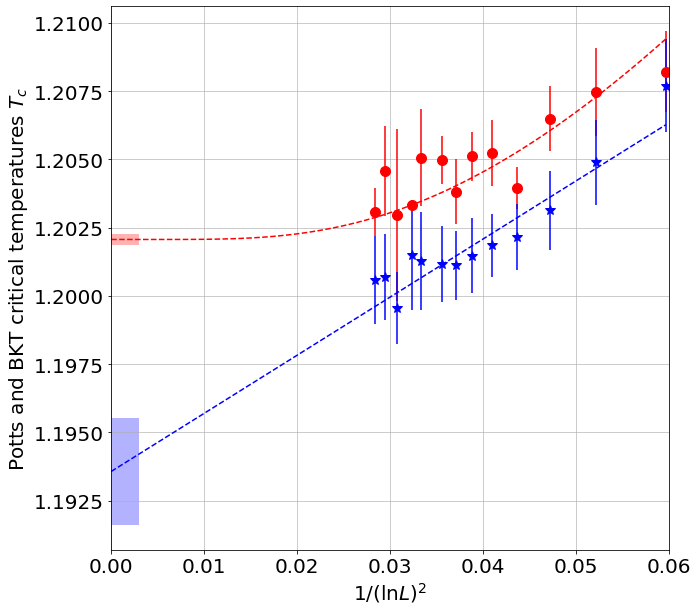

In [2]:
######
#fit picewise the BKT extrapolation

######
#- initialize plot
######

fig, ax2 = plt.subplots( figsize = (10,10))
fin = 4


########
#have an inset
#######
#list of minimum stiffness crossings
#list of T at Cv max

# Mark the region corresponding to the inset axes on ax1 and draw lines
# in grey linking the two axes.
#mark_inset(ax0, ax2, loc1=2, loc2=4, fc="none", ec='0.5')
N_list1 = N_list[fin-1:]
print('L used in first fit')
print(N_list1)
cv_result_temp_a = cv_result_temp[fin-1:]
cv_result_temp_a_err = cv_result_temp_err[fin-1:]
cross_1_a = cross_1[fin-1:]
cross_1_a_err = cross_1_err[fin-1:]

inset_xrange = 1/(np.log((N_list1))**2)
#ax2.plot(inset_xrange, tcvmax, Blocks_size[0], color = 'red')
ax2.errorbar(inset_xrange, cv_result_temp_a, yerr = cv_result_temp_a_err, fmt = 'o', color = 'red', markersize = '10')
#ax2.plot(inset_xrange, tcross, Blocks_size[1], color = 'blue')
ax2.errorbar(inset_xrange, cross_1_a, yerr = cross_1_a_err, fmt = '*', color = 'blue', markersize = '10')


#fits
#func 1
def fit_func1(Nrangex, a, b, c):
    return (a + b*Nrangex**(-(1/c)))

def fit_func1c(Nrangex, a, b):
    return (a + b*Nrangex**(-(1/(5/6))))

def fit_func1_bis(logrange, a, b,c):
    return a + b*np.exp(-1/(c*np.sqrt(logrange)))

def fit_func1_bisc(logrange, a, b):
    return a + b*np.exp(-1/((5/6)*np.sqrt(logrange)))

def fit_func1_alt(Nrangex, a, c):
    return a*(1 + Nrangex**(-(1/c)))

def fit_func1_bis_alt(logrange, a,c):
    return a*(1 + np.exp(-1/(c*np.sqrt(logrange))))

#func 2
def fit_func2(logrange, a, b):
    return a*logrange + b

#func 2- divide
def fit_func2_bis(x, a, b, a2, lm):
    return np.piecewise(x, [x < lm], [lambda x:a*x + b-a*lm, lambda x:a2*x + b-a2*lm])


line_plot_range = np.linspace(1e-7, np.max(inset_xrange), 100)


poptC, pcovC = curve_fit(fit_func1c, N_list1, cv_result_temp_a, sigma = cv_result_temp_a_err,\
 absolute_sigma = True, p0 = [1.2, 1.2], bounds = ([1., 1.],[1.5, 1.5]), maxfev = 9000)
#poptC, pcovC = curve_fit(fit_func1, N_list1, cv_result_temp_a, sigma = cv_result_temp_a_err,\
# absolute_sigma = True, p0 = [1.2, 1.2, 0.8], bounds = ([1., 1., 0.6],[1.5, 1.5, 1.0]), maxfev = 9000)
#poptC, pcovC = curve_fit(fit_func1_alt, N_list_extra, cv_result_temp, sigma = cv_result_temp_err,\
# absolute_sigma = True, p0 = [1.2, 0.8], bounds = ([1.,  0.6],[1.5,  1.0]), maxfev = 9000)
valTCV = poptC[0]
errTCV = np.sqrt(np.diag(pcovC))[0]
print('fit of T for CV')
print(valTCV)
print(errTCV)
print(poptC[1])
print(np.sqrt(np.diag(pcovC))[1])

print('nu')
#print(poptC[2])
#print(np.sqrt(np.diag(pcovC))[2])
#ax2.plot(line_plot_range, fit_func1_bis(line_plot_range, *poptC), '--', color = 'red')
ax2.plot(line_plot_range, fit_func1_bisc(line_plot_range, *poptC), '--', color = 'red')
#ax2.plot(line_plot_range, fit_func1_bis_alt(line_plot_range, *poptC), '--', color = 'red')



#fit 2 BKT
#poptB, pcovB = curve_fit(fit_func2, inset_xrange, cross_1, sigma = cross_1_err, absolute_sigma = True)
poptB, pcovB = curve_fit(fit_func2, inset_xrange, cross_1_a, sigma = cross_1_a_err, absolute_sigma = True )
valTBKT = poptB[1] 
errTBKT = np.sqrt(np.diag(pcovB))[1]
print('fit of T for KT')
print(valTBKT)
print(errTBKT)
print(poptB[0])
print(np.sqrt(np.diag(pcovB))[0])
#print('length of change')
#print(np.exp(np.sqrt(1/poptB[3])))
#ax2.plot(line_plot_range, fit_func2(line_plot_range, *poptB), '--', color = 'blue')
ax2.plot(line_plot_range, fit_func2(line_plot_range, *poptB), '--', color = 'blue')

####
#compute chances of overlap
mu1=valTBKT
sigma1=errTBKT
mu2=valTCV
sigma2=errTCV
c = (mu2*sigma1**2 - sigma2*(mu1*sigma2 + sigma1*np.sqrt((mu1 - mu2)**2 + 2*(sigma1**2 - sigma2**2)*np.log(sigma1/sigma2))))/(sigma1**2 - sigma2**2)

prob = 1 - 0.5*math.erf((c - mu1)/(np.sqrt(2)*sigma1)) + 0.5*math.erf((c - mu2)/(np.sqrt(2)*sigma2))
print('probability of overlap of Tcs in %')
print(prob*100)



ax2.set_xlim([0, 0.06])
ax2.set_xlabel(r'$1/(\ln{L})^2$', fontsize = 20)
ax2.set_ylabel(r'Potts and BKT critical temperatures $T_c$', fontsize = 20)
#ax2.yaxis.set_label_coords(0.01, 1.08)


# Create patch collection with specified colour/alpha
pcCV = patches.Rectangle((0.0, valTCV - errTCV), 0.003, 2*errTCV, facecolor='red', alpha=0.3,
                     edgecolor='none')
# Add collection to axes
ax2.add_patch(pcCV)

# Create patch collection with specified colour/alpha
pcBKT = patches.Rectangle((0.0, valTBKT - errTBKT), 0.003, 2*errTBKT, facecolor='blue', alpha=0.3,
                     edgecolor='none')
# Add collection to axes
ax2.add_patch(pcBKT)
ax2.grid(which='major', axis='both', linestyle='-', alpha = 0.8)
ax2.grid(which='minor', axis='both', linestyle='-', alpha = 0.3)
ax2.tick_params(axis='both', which='major', labelsize=20)



###########
#add an inset
###########
"""
left, bottom, width, height = [0.6, 0.2, 0.25, 0.25]
ax3 = fig.add_axes([left, bottom, width, height])

N_list2 = N_list[:fin]
cv_result_temp_b = cv_result_temp[:fin]
cv_result_temp_b_err = cv_result_temp_err[:fin]
cross_1_b = cross_1[:fin]
cross_1_b_err = cross_1_err[:fin]

inset_xrange_b = 1/(np.log((N_list2))**2)
ax3.errorbar(inset_xrange_b, cv_result_temp_b, yerr = cv_result_temp_b_err, fmt = 'o', color = 'red')
ax3.errorbar(inset_xrange_b, cross_1_b, yerr = cross_1_b_err, fmt = '*', color = 'blue')

line_plot_range_b = np.linspace(np.min(inset_xrange_b), np.max(inset_xrange_b), 100)

print()
print('For the inset fit')
print()

print('L used in second fit')
print(N_list2)


poptC, pcovC = curve_fit(fit_func1, N_list2, cv_result_temp_b, sigma = cv_result_temp_b_err,\
 absolute_sigma = True, p0 = [1.2, 1.2, 0.8], bounds = ([1., 1., 0.6],[1.5, 1.5, 1.0]), maxfev = 9000)
#poptC, pcovC = curve_fit(fit_func1_alt, N_list_extra, cv_result_temp, sigma = cv_result_temp_err,\
# absolute_sigma = True, p0 = [1.2, 0.8], bounds = ([1.,  0.6],[1.5,  1.0]), maxfev = 9000)
valTCV = poptC[0]
errTCV = np.sqrt(np.diag(pcovC))[0]
print('fit of T for CV')
print(valTCV)
print(errTCV)

print('nu')
print(poptC[2])
print(np.sqrt(np.diag(pcovC))[2])
ax3.plot(line_plot_range_b, fit_func1_bis(line_plot_range_b, *poptC), '--', color = 'red')
#ax2.plot(line_plot_range, fit_func1_bis_alt(line_plot_range, *poptC), '--', color = 'red')

#fit 2 BKT
#poptB, pcovB = curve_fit(fit_func2, inset_xrange, cross_1, sigma = cross_1_err, absolute_sigma = True)
poptB, pcovB = curve_fit(fit_func2, inset_xrange_b, cross_1_b, sigma = cross_1_b_err, absolute_sigma = True )
valTBKT = poptB[1] 
errTBKT = np.sqrt(np.diag(pcovB))[1]
print('fit of T for KT')
print(valTBKT)
print(errTBKT)
#print('length of change')
#print(np.exp(np.sqrt(1/poptB[3])))
#ax2.plot(line_plot_range, fit_func2(line_plot_range, *poptB), '--', color = 'blue')
ax3.plot(line_plot_range_b, fit_func2(line_plot_range_b, *poptB), '--', color = 'blue')
ax3.grid(which='major', axis='both', linestyle='-', alpha = 0.8)
ax3.grid(which='minor', axis='both', linestyle='-', alpha = 0.3)
ax3.set_xlabel(r'$1/(\ln{L})^2$', fontsize = 14)
ax3.set_ylabel(r'Critical Temperatures $T_c$', fontsize = 14)
"""


plt.savefig('./fig-interpolate-2.png', format='png', dpi = 100, bbox_inches='tight')
plt.show()
#plt.close()